1. Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from openpyxl import Workbook



2. Cargar datos

In [2]:
df = pd.read_excel("C:\\Users\\Valentina Molina\\Documents\\repositorios\\Proyecto_II\\datos\\Bas_de_datos_riesgos_original_30.09.2025.xlsx")

3. Limpieza de datos

In [3]:
for col in df.columns:
    print(col)

Proyecto_CD
Proyecto_DS
UEN_DS
NombreEmpleado_DS
ApellidoEmpleado_DS
Severidad_DS
Riesgo_CD
Estado_DS
Creacion_DT
Actualizacion_DT
CantidadSeveridad_NM
CantidadMaterializada_NM
Insercion_DT
ValorInterno_VR
ValorCliente_VR
NombreRiesgo_DS
Causa_DS
DetalleCausa_DS
Fuente_DS
DescripcionRiesgo_DS
FechaIdentificacion_DT
PlanAccion_DS
FechaSeguimiento_DT
ObservacionSeguimiento_DS
CantidadSeguimientos_NM
EsfuerzoSeguimiento_NM
Periocidad_DS
Cliente_DS
PRY_REQUIERE_RIESGOS
Tipo_Proyecto
Metodologia
AgenteGenerador_DS


In [4]:
df = df.drop(columns=["Proyecto_DS", "UEN_DS", "NombreEmpleado_DS", "ApellidoEmpleado_DS", "Creacion_DT", 
                      "Actualizacion_DT", "CantidadSeveridad_NM", "Insercion_DT", "NombreRiesgo_DS", "Fuente_DS", "DescripcionRiesgo_DS",
                      "FechaIdentificacion_DT", "PlanAccion_DS", "ObservacionSeguimiento_DS", "CantidadSeguimientos_NM",
                      "EsfuerzoSeguimiento_NM", "Periocidad_DS", "Cliente_DS", "PRY_REQUIERE_RIESGOS", "Tipo_Proyecto", "Metodologia"])


In [5]:
df.head()

,Proyecto_CD,Severidad_DS,Riesgo_CD,Estado_DS,CantidadMaterializada_NM,ValorInterno_VR,ValorCliente_VR,Causa_DS,DetalleCausa_DS,FechaSeguimiento_DT,AgenteGenerador_DS
0,10468,NaN,NaN,NO VIGENTE,0,0,0,NaN,NaN,NaT,NaN
1,11051,NaN,NaN,NO VIGENTE,0,0,0,NaN,NaN,NaT,NaN
2,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-06-25,Gerente de Servicio
3,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-07-24,Gerente de Servicio
4,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-08-13,Gerente de Servicio


In [6]:
df = df[df["Estado_DS"] != "NO VIGENTE"]


In [7]:
df["Estado_DS"].unique()

array(['VIGENTE'], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7822 entries, 2 to 10411
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Proyecto_CD               7822 non-null   int64         
 1   Severidad_DS              7822 non-null   object        
 2   Riesgo_CD                 7822 non-null   float64       
 3   Estado_DS                 7822 non-null   object        
 4   CantidadMaterializada_NM  7822 non-null   int64         
 5   ValorInterno_VR           7822 non-null   int64         
 6   ValorCliente_VR           7822 non-null   int64         
 7   Causa_DS                  7822 non-null   object        
 8   DetalleCausa_DS           6178 non-null   object        
 9   FechaSeguimiento_DT       7735 non-null   datetime64[ns]
 10  AgenteGenerador_DS        7822 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 733.3+ KB


In [9]:
columnas_categoricas=["Severidad_DS","Estado_DS","Causa_DS","DetalleCausa_DS", "AgenteGenerador_DS"]
df[columnas_categoricas]=df[columnas_categoricas].astype("category")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7822 entries, 2 to 10411
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Proyecto_CD               7822 non-null   int64         
 1   Severidad_DS              7822 non-null   category      
 2   Riesgo_CD                 7822 non-null   float64       
 3   Estado_DS                 7822 non-null   category      
 4   CantidadMaterializada_NM  7822 non-null   int64         
 5   ValorInterno_VR           7822 non-null   int64         
 6   ValorCliente_VR           7822 non-null   int64         
 7   Causa_DS                  7822 non-null   category      
 8   DetalleCausa_DS           6178 non-null   category      
 9   FechaSeguimiento_DT       7735 non-null   datetime64[ns]
 10  AgenteGenerador_DS        7822 non-null   category      
dtypes: category(5), datetime64[ns](1), float64(1), int64(4)
memory usage: 468.4 KB


4. Creación de nuevas variables

In [11]:
riesgos_criticos = (
    df.groupby("Riesgo_CD")
    .apply(lambda x: any((x["ValorInterno_VR"] > 0) | (x["ValorCliente_VR"] > 0)))
    .reset_index(name="materializado")
)

df = df.merge(riesgos_criticos, on="Riesgo_CD", how="left")
df["Critico"] = np.where(df["materializado"], 1, 0)


C:\Users\Valentina Molina\AppData\Local\Temp\ipykernel_31020\1032350668.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: any((x["ValorInterno_VR"] > 0) | (x["ValorCliente_VR"] > 0)))


In [12]:
def materializado(grupo):
    fechas = grupo["FechaSeguimiento_DT"].values.astype('datetime64[ns]')
    interno = grupo["ValorInterno_VR"].fillna(0).values
    cliente = grupo["ValorCliente_VR"].fillna(0).values
    resultado = []
    for i, f in enumerate(fechas):
        fecha_limite = f + np.timedelta64(30, 'D')   # <-- cambio clave
        hay_evento = np.any(
            (fechas > f)
            & (fechas <= fecha_limite)
            & ((interno > 0) | (cliente > 0))
        )
        resultado.append(hay_evento)
    grupo["materializado"] = resultado
    return grupo

In [13]:
print(df.columns.tolist())

['Proyecto_CD', 'Severidad_DS', 'Riesgo_CD', 'Estado_DS', 'CantidadMaterializada_NM', 'ValorInterno_VR', 'ValorCliente_VR', 'Causa_DS', 'DetalleCausa_DS', 'FechaSeguimiento_DT', 'AgenteGenerador_DS', 'materializado', 'Critico']


In [14]:
df["valor_acumulado"] = df["ValorInterno_VR"].fillna(0) + df["ValorCliente_VR"].fillna(0)

df2 = df.dropna(subset=["FechaSeguimiento_DT", "Severidad_DS", "materializado"])

# Convertir a categorías y binario
mapa_severidad = {
    "Riesgo Bajo": 1,
    "Riesgo Medio": 2,
    "Riesgo Significativo": 3,
    "Riesgo Alto": 4,
    "Riesgo Crítico": 5
}
df2["Severidad_NUM"] = df2["Severidad_DS"].map(mapa_severidad)
df2["materializado"] = df2["materializado"].astype(int)

C:\Users\Valentina Molina\AppData\Local\Temp\ipykernel_31020\2057381633.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Severidad_NUM"] = df2["Severidad_DS"].map(mapa_severidad)
C:\Users\Valentina Molina\AppData\Local\Temp\ipykernel_31020\2057381633.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["materializado"] = df2["materializado"].astype(int)


In [15]:
df2.head()

,Proyecto_CD,Severidad_DS,Riesgo_CD,Estado_DS,CantidadMaterializada_NM,ValorInterno_VR,ValorCliente_VR,Causa_DS,DetalleCausa_DS,FechaSeguimiento_DT,AgenteGenerador_DS,materializado,Critico,valor_acumulado,Severidad_NUM
0,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-06-25,Gerente de Servicio,0,0,0,4
1,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-07-24,Gerente de Servicio,0,0,0,4
2,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-08-13,Gerente de Servicio,0,0,0,4
3,11405,Riesgo Bajo,3592.0,VIGENTE,0,0,0,Legislación,Desconocimiento,2021-03-17,Proceso,0,0,0,1
4,11405,Riesgo Bajo,3592.0,VIGENTE,0,0,0,Legislación,Desconocimiento,2021-04-27,Proceso,0,0,0,1


5. Análisis descriptivo

In [16]:
print("\nResumen estadístico de variables numéricas:")
df2.select_dtypes(include=["number"]).describe().T


Resumen estadístico de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Proyecto_CD,7735.0,12502.459470,476.077615,11405.0,12224.0,12735.0,12847.0,13052.0
Riesgo_CD,7735.0,4417.572851,906.897778,1979.0,4014.0,4614.0,5149.0,5707.0
CantidadMaterializada_NM,7735.0,0.549838,2.295658,0.0,0.0,0.0,0.0,21.0
ValorInterno_VR,7735.0,14576.311829,413393.108686,0.0,0.0,0.0,0.0,23555600.0
ValorCliente_VR,7735.0,7810.291920,327979.310460,0.0,0.0,0.0,0.0,19070000.0
materializado,7735.0,0.071622,0.257878,0.0,0.0,0.0,0.0,1.0
Critico,7735.0,0.071622,0.257878,0.0,0.0,0.0,0.0,1.0
valor_acumulado,7735.0,22386.603749,557975.953993,0.0,0.0,0.0,0.0,24000000.0


In [17]:
print("\nResumen de variables categóricas:")
df2.select_dtypes(include=["category"]).describe().T


Resumen de variables categóricas:


,count,unique,top,freq
Severidad_DS,7735,5,Riesgo Significativo,3200
Estado_DS,7735,1,VIGENTE,7735
Causa_DS,7735,19,Seguridad,2006
DetalleCausa_DS,6143,19,Insuficiencia-Deficiencia,3455
AgenteGenerador_DS,7735,18,Recursos/Insumos/Tecnología,2313
Severidad_NUM,7735,5,3,3200


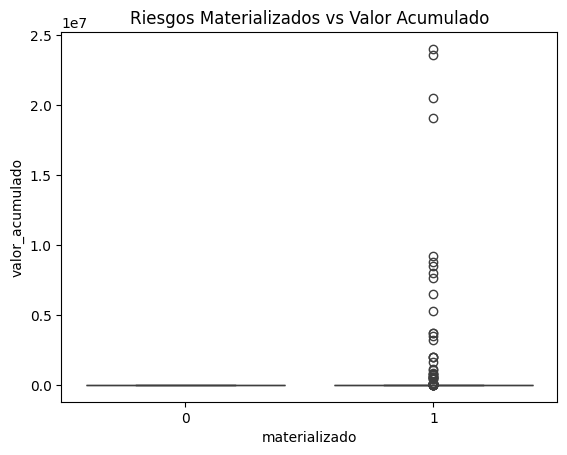

In [18]:
# Visualización por riesgos materializados
sns.boxplot(x="materializado", y="valor_acumulado", data=df2)
plt.title("Riesgos Materializados vs Valor Acumulado")
plt.show()

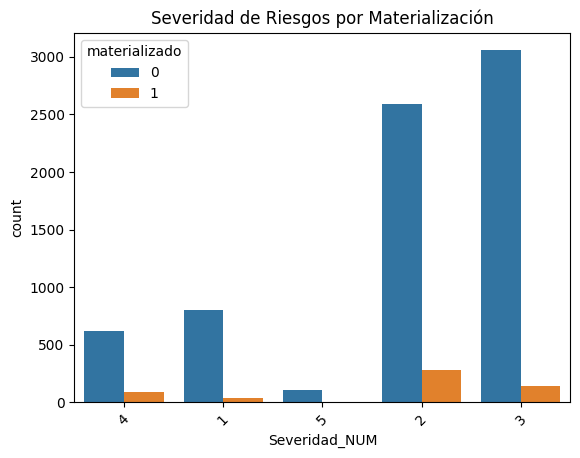

In [19]:
sns.countplot(x="Severidad_NUM", hue="materializado", data=df2)
plt.title("Severidad de Riesgos por Materialización")
plt.xticks(rotation=45)
plt.show()

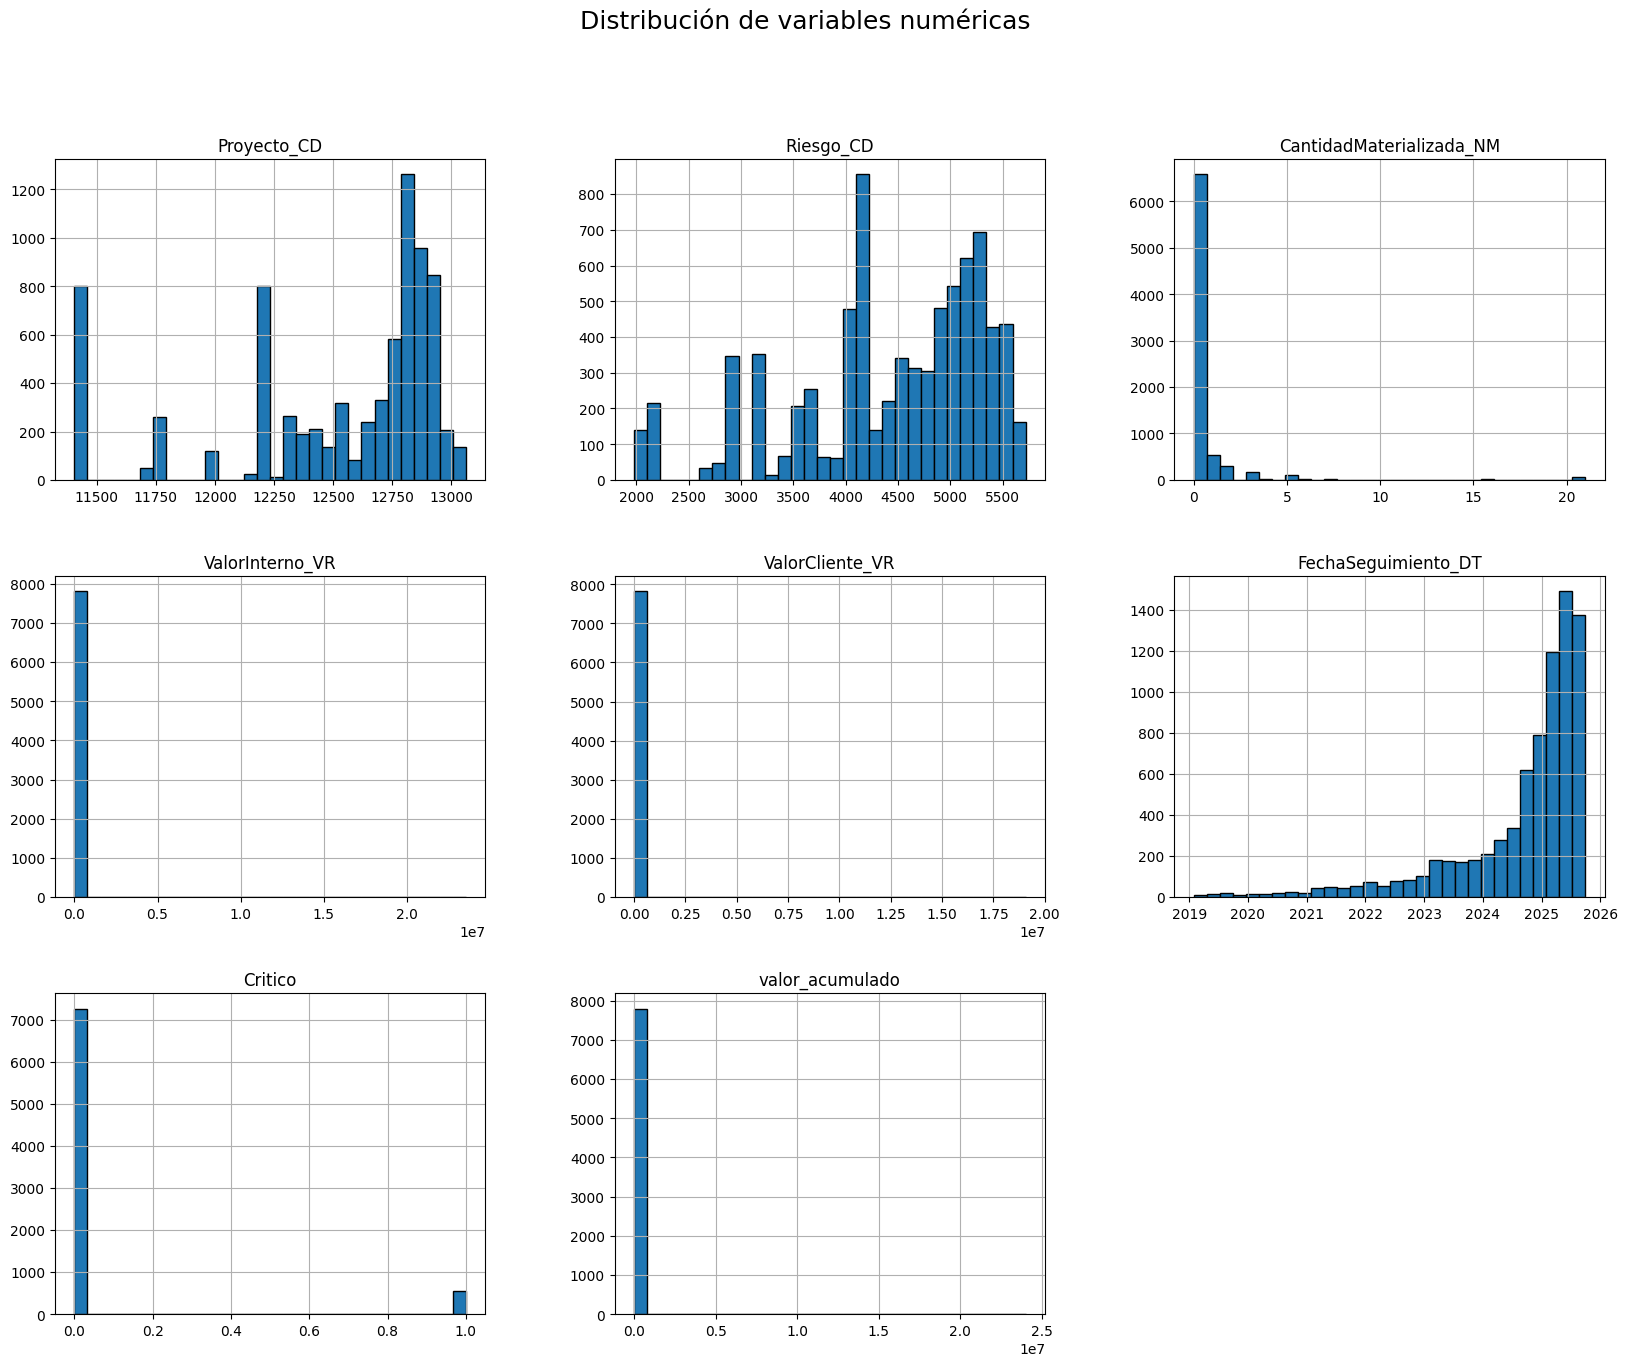

In [20]:
df.hist(bins=30, figsize=(20,15), edgecolor="black")
plt.suptitle("Distribución de variables numéricas", fontsize=18)
plt.show()

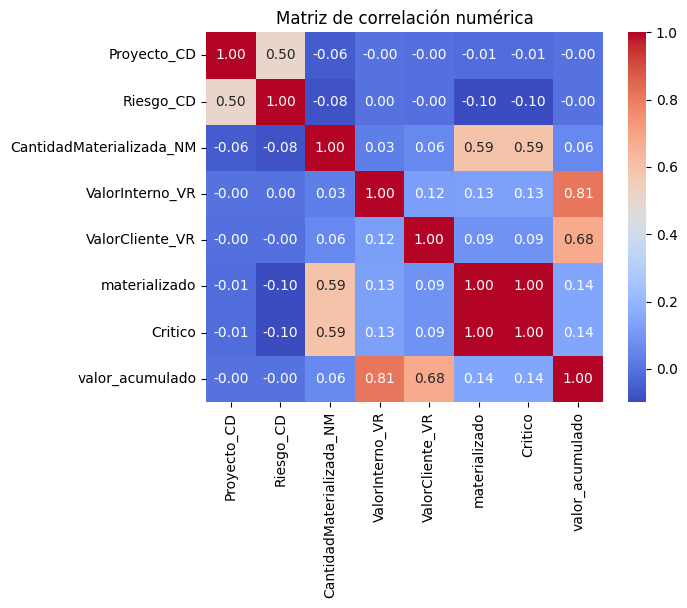

In [21]:
# Correlación entre variables numéricas
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación numérica")
plt.show()

6. Modelo Random Forest

In [22]:
X = df2[["Severidad_NUM", "valor_acumulado"]]
y = df2["materializado"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [24]:
df2.loc[y_test.index]["Riesgo_CD"],

(4431    5090.0
 5640    5197.0
 4902    4135.0
 3351    5142.0
 1147    4182.0
          ...  
 4168    4137.0
 7517    5517.0
 274     3132.0
 3851    5246.0
 2684    4693.0
 Name: Riesgo_CD, Length: 1547, dtype: float64,)

In [25]:
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=123)
modelo_rf.fit(X_train, y_train)

y_pred = modelo_rf.predict(X_test)

In [26]:
print("Matriz de confusión (modelo sin balanceo):")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Matriz de confusión (modelo sin balanceo):
[[1436    0]
 [  98   13]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1436
           1       1.00      0.12      0.21       111

    accuracy                           0.94      1547
   macro avg       0.97      0.56      0.59      1547
weighted avg       0.94      0.94      0.91      1547



In [27]:
rus = RandomUnderSampler(random_state=123)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

modelo_rf_bal = RandomForestClassifier(n_estimators=100, random_state=123)
modelo_rf_bal.fit(X_train_bal, y_train_bal)

y_pred_bal = modelo_rf_bal.predict(X_test)
print("\nMatriz de confusión (modelo balanceado):")
print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))


Matriz de confusión (modelo balanceado):
[[814 622]
 [ 36  75]]
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      1436
           1       0.11      0.68      0.19       111

    accuracy                           0.57      1547
   macro avg       0.53      0.62      0.45      1547
weighted avg       0.90      0.57      0.67      1547



AUC: 0.657


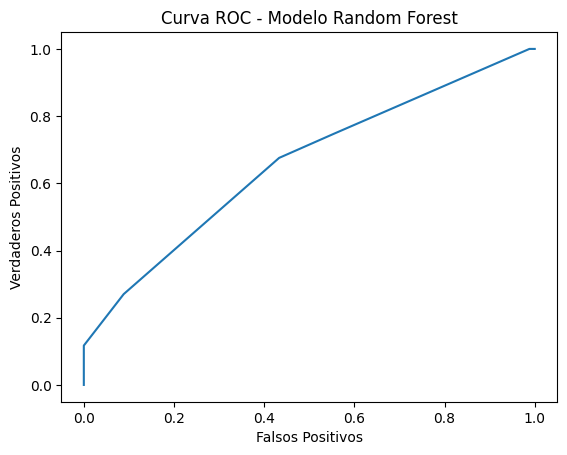

Mejor umbral según ROC: 0.563


In [28]:
probs = modelo_rf_bal.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)
print(f"AUC: {auc:.3f}")

plt.figure()
plt.plot(fpr, tpr)
plt.title("Curva ROC - Modelo Random Forest")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.show()

# Mejor umbral según ROC (Youden)
youden_idx = np.argmax(tpr - fpr)
umbral_optimo = thresholds[youden_idx]
print(f"Mejor umbral según ROC: {umbral_optimo:.3f}")

In [29]:
pred_opt = (probs >= umbral_optimo).astype(int)
print("\nMatriz de confusión con umbral óptimo:")
print(confusion_matrix(y_test, pred_opt))
print(classification_report(y_test, pred_opt))


Matriz de confusión con umbral óptimo:
[[814 622]
 [ 36  75]]
              precision    recall  f1-score   support

           0       0.96      0.57      0.71      1436
           1       0.11      0.68      0.19       111

    accuracy                           0.57      1547
   macro avg       0.53      0.62      0.45      1547
weighted avg       0.90      0.57      0.67      1547



In [30]:
resultados = pd.DataFrame({
    "Riesgo_CD": df2.loc[y_test.index]["Riesgo_CD"],
    "Prob_Materializacion": probs,
    "Predicho_Materializado": pred_opt,
    "Real_Materializado": y_test
})
resultados.to_excel("Predicciones_Modelo_RF.xlsx", index=False)
print("Archivo 'Predicciones_Modelo_RF.xlsx' creado exitosamente.")

Archivo 'Predicciones_Modelo_RF.xlsx' creado exitosamente.


In [31]:
df2.shape, y_test.shape

((7735, 15), (1547,))

In [32]:
y_test.index.values

array([4431, 5640, 4902, ...,  274, 3851, 2684], shape=(1547,))

In [33]:
y_test

4431    0
5640    0
4902    0
3351    0
1147    0
       ..
4168    0
7517    0
274     0
3851    0
2684    1
Name: materializado, Length: 1547, dtype: int64

In [34]:
df2["Riesgo_CD"].reindex(y_test.index).values

array([5090., 5197., 4135., ..., 3132., 5246., 4693.], shape=(1547,))

In [35]:
verdaderos_positivos = np.sum((pred_opt == 1) & (y_test == 1))
total_positivos = np.sum(y_test == 1)
tasa_deteccion_temprana = (verdaderos_positivos / total_positivos) * 100
print(f"Tasa de detección temprana: {tasa_deteccion_temprana:.2f}%")

Tasa de detección temprana: 67.57%


6.1 Entrenamiento balaceado y test desbalanceado

In [36]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
rus = RandomUnderSampler(random_state=42)
X_train2_bal, y_train2_bal = rus.fit_resample(X_train2, y_train2)

In [38]:
modelo_rf2_bal = RandomForestClassifier(n_estimators=100, random_state=123)
modelo_rf2_bal.fit(X_train2_bal, y_train2_bal)

y_pred2 = modelo_rf2_bal.predict_proba(X_test2)[:, 1]

In [39]:
print("Distribución después del balanceo:")
print(y_train2_bal.value_counts())

Distribución después del balanceo:
materializado
0    443
1    443
Name: count, dtype: int64


In [40]:
# 2️⃣ Entrenar el modelo balanceado
modelo_rf2_bal = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
modelo_rf2_bal.fit(X_train2_bal, y_train2_bal)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [41]:
y_pred2 = modelo_rf2_bal.predict_proba(X_test2)[:, 1]

AUC del modelo RF2 balanceado: 0.689


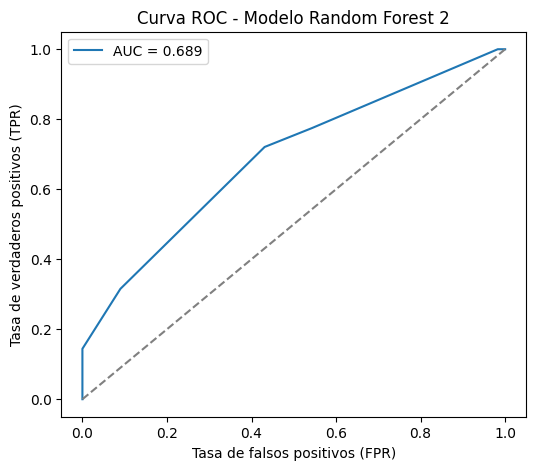

Mejor umbral según ROC (Youden): 0.580


In [42]:
# Predicciones probabilísticas
y_pred2 = modelo_rf2_bal.predict_proba(X_test2)[:, 1]

# Curva ROC y AUC
fpr2, tpr2, thresholds2 = roc_curve(y_test2, y_pred2)
auc2 = roc_auc_score(y_test2, y_pred2)
print(f"AUC del modelo RF2 balanceado: {auc2:.3f}")

# Gráfico ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr2, tpr2, label=f"AUC = {auc2:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("Curva ROC - Modelo Random Forest 2")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.legend()
plt.show()

# Mejor umbral según Youden
youden_idx2 = np.argmax(tpr2 - fpr2)
umbral_optimo2 = thresholds2[youden_idx2]
print(f"Mejor umbral según ROC (Youden): {umbral_optimo2:.3f}")


In [43]:
# Aplicar el umbral óptimo encontrado para clasificar
y_pred2_umbral = (y_pred2 >= umbral_optimo2).astype(int)

# Matriz de confusión y reporte de clasificación
print("\nMatriz de confusión con umbral óptimo:")
print(confusion_matrix(y_test2, y_pred2_umbral))
print(classification_report(y_test2, y_pred2_umbral))



Matriz de confusión con umbral óptimo:
[[817 619]
 [ 31  80]]
              precision    recall  f1-score   support

           0       0.96      0.57      0.72      1436
           1       0.11      0.72      0.20       111

    accuracy                           0.58      1547
   macro avg       0.54      0.64      0.46      1547
weighted avg       0.90      0.58      0.68      1547



In [44]:
verdaderos_positivos = np.sum((y_pred2_umbral == 1) & (y_test2 == 1))
total_positivos = np.sum(y_test2 == 1)
tasa_deteccion_temprana = (verdaderos_positivos / total_positivos) * 100
print(f"Tasa de detección temprana: {tasa_deteccion_temprana:.2f}%")

Tasa de detección temprana: 72.07%
